# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Business Understanding

Reading the the project introduction and overview, the questions we decided to explore in this analysis are
which demographic groups respond best to which offer type**
What factors mainly affect the usage of the offer from customer? Should the company send out the offer or not?
How possible will a customer open and use the offer sent to them? Is there any common characteristics on the customers who take the offer?

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
% matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


We see that portfolio has only 10 rows and no missing values.

In [4]:
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [5]:
portfolio.groupby('offer_type').id.count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.shape

(17000, 5)

The profile dataset has 17k rows. However, looking at the first rows, we see a lot of NaN values, as well as values that don't make sense(age 118) that we need to clean.

In [8]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [9]:
profile[profile.age == 118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

As it seems, the number 118 is the value for NaN in the age column, and the same rows have missing values in the gender and income columns too, so we will drop them.

In [10]:
profile[profile.age==118].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [11]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [12]:
transcript.shape

(306534, 4)

In [13]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [14]:
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [15]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

All columns in transcript seem ok except the values one that is a dictionary that we should break down a bit

# Data preprocessing

### Clean profile dataset

In [16]:
def one_hot_encoding(df, column_list):
    
    for column in column_list:
        column_dummies = pd.get_dummies(df[column])
        df = df.drop(column, axis = 1)
        df = df.join(column_dummies)
    return df

In [17]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [18]:
# Drop raws with age 118, which correspond to rows with null values in gender and income too
profile = profile[profile.age < 118].reset_index(drop=True)

# Replace dates of on profile df with datetime values
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')
profile = profile.rename(columns={"id": "person_id"})
profile.head()

,age,became_member_on,gender,person_id,income
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


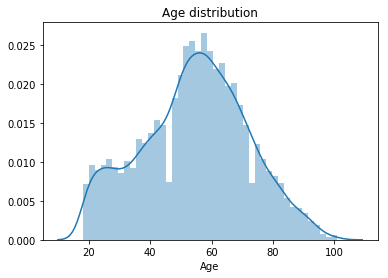

In [19]:
ax = sns.distplot(profile['age'])
ax.set(xlabel='Age')
ax.set_title('Age distribution')
# plt.savefig('plots/age.png', bbox_inches='tight')
plt.show()


In [20]:
mean_age = profile['age'].mean()

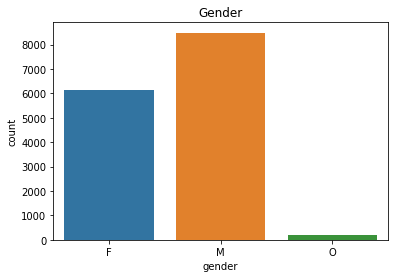

In [21]:
plt.title('Gender')
sns.countplot(x='gender', data=profile)

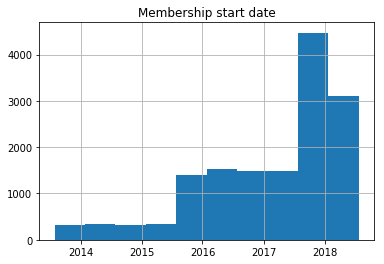

In [22]:
plt.title('Membership start date')
profile['became_member_on'].hist()

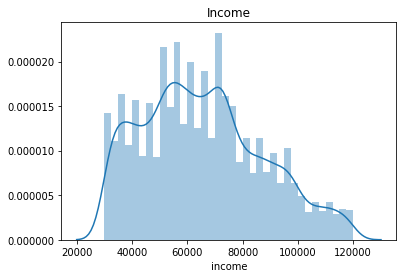

In [23]:
plt.title('Income')
sns.distplot(profile['income'])

In [24]:
# Convert became_member_on to membership length in days

profile['member_days'] =  datetime.today()
profile['member_days'] = (profile['member_days'] - profile['became_member_on'])
profile['member_days'] = profile['member_days'].dt.days
profile_clean = profile.drop("became_member_on", axis=1)
profile_clean.head()

,age,gender,person_id,income,member_days
0,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1065
1,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1132
2,68,M,e2127556f4f64592b11af22de27a7932,70000.0,780
3,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,856
4,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,946


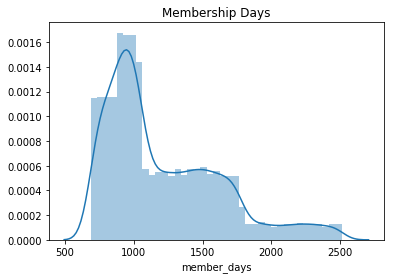

In [25]:
plt.title('Membership Days')
sns.distplot(profile['member_days'])

In [26]:
# According to the distribution, we will take the mean or median to impute values later
mean_age = profile['age'].mean()
median_income = profile['income'].median()
median_member = profile['member_days'].median()

In [27]:


profile_clean = one_hot_encoding(profile_clean, ['gender'])

### Clean transcript dataframe

In [28]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [29]:

transcript_clean = one_hot_encoding(transcript, ['event'])
transcript_clean.head()

,person,time,value,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [30]:
# Find keys of value columns
def find_keys(df, column_name):

    keys = []
    for i in range(df.shape[0]):
        for key, value in df[column_name][i].items():
            if key not in keys:
                keys.append(key)
    return keys
    
      
value_keys = find_keys(transcript_clean, 'value')
value_keys    
transcript_clean['value'][1]

{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}

In [31]:
def clean_dict(df, column_name):

    for i in range(df.shape[0]):
        for key, value in df[column_name][i].items():
            if key == 'offer id':
                # dict[new_key] = dict.pop(old_key)
                (df[column_name][i])['offer_id'] = (df[column_name][i]).pop(key)
    return df


transcript_clean =  clean_dict(transcript_clean, 'value')
value_keys = find_keys(transcript_clean, 'value')
value_keys  

['offer_id', 'amount', 'reward']

In [32]:
# Transform each key of value column into column and add it to the dataframe

transcript_clean = pd.concat([transcript_clean, transcript_clean['value'].apply(pd.Series)], axis=1)
transcript_clean.head()

,person,time,value,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [33]:
# Check if reward was set correclty (for columns with positve reward, there was a reward key in the value column)

transcript_clean[transcript_clean.reward > 0]['value'].values

array([{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2},
       {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2},
       {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}, ...,
       {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2},
       {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2},
       {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}], dtype=object)

In [34]:
transcript_clean = transcript_clean.drop('value', axis=1)
transcript_clean['reward'].fillna(0, inplace=True)
transcript_clean['amount'].fillna(0, inplace=True)
transcript_clean = transcript_clean.rename(columns={"person": "person_id"})
transcript_clean.head()


,person_id,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [35]:
transcript_clean.amount.describe()

count    306534.000000
mean          5.792023
std          21.337137
min           0.000000
25%           0.000000
50%           0.000000
75%           7.100000
max        1062.280000
Name: amount, dtype: float64

In [36]:
transcript_clean['offer_id'].nunique()

10

### Clean portfolio

In [37]:
# Convert channels to categorical and then get dummies

channels = portfolio['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})

portfolio_clean=pd.concat([portfolio[:], channels[:]], axis=1)
portfolio_clean['web'] = np.where(portfolio_clean['web']=='web',1,0)
portfolio_clean['email'] = np.where(portfolio_clean['email']=='email',1,0)
portfolio_clean['mobile'] = np.where(portfolio_clean['mobile']=='mobile',1,0)
portfolio_clean['social'] = np.where(portfolio_clean['social']=='social',1,0)

portfolio_clean=portfolio_clean.drop('channels',axis=1)

#portfolio_clean #bug in 1st row


portfolio_clean.rename(columns={'id':'offer_id'}, inplace=True)
portfolio_clean

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,0,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,0,0,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [38]:
portfolio_clean['offer_id'].nunique()

10

In [39]:
# Merge on offer_id
transcript_portfolio = pd.merge(transcript_clean, portfolio_clean, how="left", on='offer_id')
transcript_portfolio.head()

,person_id,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_x,difficulty,duration,offer_type,reward_y,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,20.0,10.0,discount,5.0,1.0,1.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,10.0,7.0,discount,2.0,1.0,1.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [40]:
transcript_portfolio.amount.describe()

count    306534.000000
mean          5.792023
std          21.337137
min           0.000000
25%           0.000000
50%           0.000000
75%           7.100000
max        1062.280000
Name: amount, dtype: float64

In [41]:
transactions = transcript_portfolio.loc[transcript_portfolio.transaction == 1]
# transactions = transactions.dropna(subset=["offer_id"])

transactions = transactions[['person_id','time','amount']]
# transactions.amount.describe()
transactions.head()

,person_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [42]:
df = pd.merge(transcript_portfolio, profile_clean, how="left", on='person_id')
df.head()

,person_id,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_x,difficulty,...,web,email,mobile,social,age,income,member_days,F,M,O
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,5.0,...,1.0,1.0,1.0,0.0,75.0,100000.0,1132.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,20.0,...,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,10.0,...,1.0,1.0,1.0,0.0,68.0,70000.0,780.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0,10.0,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,10.0,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
df.amount.describe()

count    306534.000000
mean          5.792023
std          21.337137
min           0.000000
25%           0.000000
50%           0.000000
75%           7.100000
max        1062.280000
Name: amount, dtype: float64

In [44]:
df= df.drop(['reward_x','reward_y'], axis=1)


In [45]:
df=df.sort_values(['person_id','time'])
df.head()

,person_id,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,difficulty,duration,...,web,email,mobile,social,age,income,member_days,F,M,O
55972,0009655768c64bdeb2e877511632db8f,168,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,3.0,...,0.0,0.0,0.0,0.0,33.0,72000.0,1150.0,0.0,1.0,0.0
77705,0009655768c64bdeb2e877511632db8f,192,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,3.0,...,0.0,0.0,0.0,0.0,33.0,72000.0,1150.0,0.0,1.0,0.0
89291,0009655768c64bdeb2e877511632db8f,228,0,0,0,1,NaN,22.16,NaN,NaN,...,NaN,NaN,NaN,NaN,33.0,72000.0,1150.0,0.0,1.0,0.0
113605,0009655768c64bdeb2e877511632db8f,336,0,1,0,0,3f207df678b143eea3cee63160fa8bed,0.00,0.0,4.0,...,1.0,1.0,1.0,0.0,33.0,72000.0,1150.0,0.0,1.0,0.0
139992,0009655768c64bdeb2e877511632db8f,372,0,0,1,0,3f207df678b143eea3cee63160fa8bed,0.00,0.0,4.0,...,1.0,1.0,1.0,0.0,33.0,72000.0,1150.0,0.0,1.0,0.0


In [46]:
df.transaction.describe()

count    306534.000000
mean          0.453304
std           0.497815
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: transaction, dtype: float64

In [47]:
# Split by offer

bogo = df[df['offer_type']=='bogo'].copy()
discount = df[df['offer_type']=='discount'].copy()
informational = df[df['offer_type']=='informational'].copy()


In [48]:
informational.amount.describe()

count    26066.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: amount, dtype: float64

In [49]:
# Find offers responded

# Get offers that were received and viewed by the customer
offers_viewed = pd.merge(df.loc[df['offer received'] == 1, ['person_id', 'offer_id', 'time','duration']],
                         df.loc[df['offer viewed'] == 1, ['person_id', 'offer_id', 'time','duration']],
                 on=['person_id', 'offer_id'], how='left', suffixes=['_received', '_viewed'])

offers_viewed.head()


# Get offers that were viewed and completed by the customer
offers_completed = pd.merge(df.loc[df['offer viewed'] == 1, ['person_id', 'offer_id', 'time','duration']],
                 df.loc[df['offer completed'] == 1, ['person_id', 'offer_id', 'time','duration']],
                 on=['person_id', 'offer_id'], how='left', suffixes=['_viewed', '_completed'])


offers_viewed.head()

# Get information of all completed offers in order to check if they were within the duration of the offer
offers = pd.merge(offers_completed,
                 offers_viewed.loc[offers_viewed['time_viewed'] > 0, ['person_id', 'offer_id', 'time_received']],
                 on=['person_id', 'offer_id'], how='left')
offers.head()


,person_id,offer_id,time_viewed,duration_viewed,time_completed,duration_completed,time_received
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,3.0,NaN,NaN,168.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372,4.0,NaN,NaN,336.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,5.0,414.0,5.0,408.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540,10.0,528.0,10.0,504.0
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,216,5.0,NaN,NaN,168.0


In [50]:
# Find trasactions responded


transactions_completed = pd.merge(df.loc[df['offer viewed'] == 1, ['person_id', 'offer_id', 'time','duration']],
                 transactions,
                 on=['person_id'], how='left', suffixes=['_viewed', '_trans'])

#Get info for all transactions
transactions2 = pd.merge(transactions_completed,
                 offers_viewed.loc[offers_viewed['time_viewed'] > 0, ['person_id', 'offer_id', 'time_received']],
                 on=['person_id', 'offer_id'], how='left')
transactions2.head()

,person_id,offer_id,time_viewed,duration,time_trans,amount,time_received
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,3.0,228.0,22.16,168.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,3.0,414.0,8.57,168.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,3.0,528.0,14.11,168.0
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,3.0,552.0,13.56,168.0
4,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,3.0,576.0,10.27,168.0


In [51]:
# For all offers viewed but not necessarily completed, mark them as zero
# offers['offer_responded'] = 0

# Convert time(hours) to days
offers['day_received'] = offers['time_received']/24
offers['day_viewed'] = offers['time_viewed']/24
offers['day_completed'] = offers['time_completed']/24

offers = offers.drop(['time_viewed','time_completed','time_received'], axis=1)
offers.rename(columns={'duration_viewed': 'duration'}, inplace=True)




In [52]:
transactions2['day_viewed'] = transactions2['time_viewed']/24
transactions2['day_received'] = transactions2['time_received']/24
transactions2['day_trans'] = transactions2['time_trans']/24
transactions2 = transactions2.drop(['time_viewed','time_trans','time_received'], axis=1)


In [53]:
transactions2.head()

,person_id,offer_id,duration,amount,day_viewed,day_received,day_trans
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,22.16,8.0,7.0,9.50
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,8.57,8.0,7.0,17.25
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,14.11,8.0,7.0,22.00
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,13.56,8.0,7.0,23.00
4,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,10.27,8.0,7.0,24.00


In [54]:
# We want to keep customers who saw the offer before they completed it
condition1 = offers['day_viewed'] <  offers['day_completed'] 
# .. and they completed it within the duration of the offer
condition2 = offers['day_completed'] <= offers['day_received'] + offers['duration']
offers_responded = offers.loc[condition1 & condition2]


# Keep also those who bought anyway
condition3 = offers['day_viewed'] > offers['day_completed']
offers_completed_anyway  = offers.loc[condition3]


# Keep those who not responded = viewed but not completed
condition4 = ( (offers['day_viewed'] > 0) & (offers['day_completed'].isna()))
offers_not_responded = offers.loc[condition4]


# Clean columns
offers_responded = offers_responded.drop(['duration_completed'], axis=1)
offers_not_responded = offers_not_responded.drop(['duration_completed'], axis=1)
offers_completed_anyway = offers_completed_anyway.drop(['duration_completed'], axis=1)
offers_responded.head()


,person_id,offer_id,duration,day_received,day_viewed,day_completed
13,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,7.0,7.75,10.50
15,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,17.0,18.00,24.00
16,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,21.0,21.50,24.00
17,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,10.0,0.0,0.50,2.25
18,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,10.0,14.0,0.50,2.25


In [55]:
# Repeat for transactiona

# We want to keep transactions made after viewing in the duraion
condition5 = transactions2['day_viewed'] <  transactions2['day_trans'] 
condition6 = transactions2['day_trans'] <= transactions2['day_received'] + transactions2['duration']
transactions_responded = transactions2.loc[condition5 & condition6]
transactions_responded.rename(columns={'day_trans': 'day_completed'}, inplace=True) #rename?

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [56]:
transactions_responded.head()

,person_id,offer_id,duration,amount,day_viewed,day_received,day_completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,22.16,8.0,7.0,9.50
9,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,4.0,8.57,15.5,14.0,17.25
18,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,14.11,19.0,17.0,22.00
27,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,13.56,22.5,21.0,23.00
28,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.27,22.5,21.0,24.00


In [57]:
offers_not_responded.head()

,person_id,offer_id,duration,day_received,day_viewed,day_completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,7.0,8.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,4.0,14.0,15.5,NaN
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,7.0,9.0,NaN
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,7.0,9.0,NaN
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,24.0,9.0,NaN


In [58]:
offers_completed_anyway.head()

,person_id,offer_id,duration,day_received,day_viewed,day_completed
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,17.0,19.0,17.25
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,21.0,22.5,22.00
37,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,10.0,7.0,17.5,16.00
38,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,10.0,7.0,17.5,16.00
39,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,10.0,17.0,17.5,16.00


In [59]:
offers = offers.drop(['duration_completed'], axis=1)
offers.head()

,person_id,offer_id,duration,day_received,day_viewed,day_completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,7.0,8.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,4.0,14.0,15.5,NaN
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,17.0,19.0,17.25
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,21.0,22.5,22.00
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,7.0,9.0,NaN


In [60]:
offers_responded.sort_values(by=['person_id','offer_id'])
offers_responded.head(10)

,person_id,offer_id,duration,day_received,day_viewed,day_completed
13,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,7.0,7.75,10.50
15,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,17.0,18.00,24.00
16,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,21.0,21.50,24.00
17,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,10.0,0.0,0.50,2.25
18,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,10.0,14.0,0.50,2.25
20,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,10.0,14.0,0.50,21.25
21,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,17.0,17.75,21.25
23,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,7.0,7.00,9.25
24,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,5.0,14.0,14.50,15.75
26,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,21.0,24.25,25.00


In [61]:
transactions_responded.sort_values(by=['person_id','offer_id'])
transactions_responded.head(10)

,person_id,offer_id,duration,amount,day_viewed,day_received,day_completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,22.16,8.0,7.0,9.50
9,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,4.0,8.57,15.5,14.0,17.25
18,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,14.11,19.0,17.0,22.00
27,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,13.56,22.5,21.0,23.00
28,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.27,22.5,21.0,24.00
29,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,12.36,22.5,21.0,27.50
30,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,28.16,22.5,21.0,28.75
31,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,18.41,22.5,21.0,29.00
34,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0.70,9.0,24.0,12.25
35,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0.70,9.0,24.0,12.25


In [62]:
offers_transactions= pd.merge(offers_responded, 
                                transactions_responded, 
                                on=['person_id', 'offer_id'],
                               how='inner')


In [63]:
# check if it is the be same, if same we take transactions_responded which is the bigger valid set
offers_transactions.shape, offers_responded.shape

((2120157, 11), (52346, 6))

In [64]:
transactions_responded.head()

,person_id,offer_id,duration,amount,day_viewed,day_received,day_completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,22.16,8.0,7.0,9.50
9,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,4.0,8.57,15.5,14.0,17.25
18,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,14.11,19.0,17.0,22.00
27,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,13.56,22.5,21.0,23.00
28,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.27,22.5,21.0,24.00


In [65]:
# Maybe drop instead
transactions_responded = transactions_responded.drop("amount",axis=1)
# offers_not_responded['amount'] = 0
offers_not_responded.head()

,person_id,offer_id,duration,day_received,day_viewed,day_completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,7.0,8.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,4.0,14.0,15.5,NaN
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,7.0,9.0,NaN
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,7.0,9.0,NaN
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,24.0,9.0,NaN


In [66]:
# offers_all = pd.concat([offers_responded, offers_not_responded], keys=['person_id', 'offer_id'])
offers_all = pd.concat([transactions_responded, offers_not_responded], keys=['person_id', 'offer_id'],
                       sort=False, ignore_index=True)
offers_all.tail()

offers_all['offer_respond'] = offers_all['day_completed']
offers_all['offer_respond'] = offers_all['offer_respond'].fillna(0)
offers_all.loc[offers_all['offer_respond'] > 0, 'offer_respond'] = 1

offers_all.head()

,person_id,offer_id,duration,day_viewed,day_received,day_completed,offer_respond
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,8.0,7.0,9.50,1.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,4.0,15.5,14.0,17.25,1.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,19.0,17.0,22.00,1.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,22.5,21.0,23.00,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,22.5,21.0,24.00,1.0


In [67]:
offers_all.tail()

,person_id,offer_id,duration,day_viewed,day_received,day_completed,offer_respond
325851,fff7576017104bcc8677a8d63322b5e1,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,7.50,7.0,NaN,0.0
325852,fff7576017104bcc8677a8d63322b5e1,ae264e3637204a6fb9bb56bc8210ddfd,7.0,17.25,17.0,NaN,0.0
325853,fff8957ea8b240a6b5e634b6ee8eafcf,fafdcd668e3743c1bb461111dcafc2a4,10.0,18.00,17.0,NaN,0.0
325854,fff8957ea8b240a6b5e634b6ee8eafcf,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,27.50,24.0,NaN,0.0
325855,fffad4f4828548d1b5583907f2e9906b,5a8bc65990b245e5a138643cd4eb9837,3.0,7.00,7.0,NaN,0.0


In [68]:
offers_all['offer_respond'].value_counts()

1.0    272991
0.0     52865
Name: offer_respond, dtype: int64

In [69]:
# Merge with profile get the rest of the information
df = pd.merge(offers_all, profile_clean, on='person_id', how="left")
df.head()
# df['offer_respond'].value_counts()


,person_id,offer_id,duration,day_viewed,day_received,day_completed,offer_respond,age,income,member_days,F,M,O
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,8.0,7.0,9.50,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,4.0,15.5,14.0,17.25,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,19.0,17.0,22.00,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,22.5,21.0,23.00,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,22.5,21.0,24.00,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0


In [70]:
# portfolio = df[df['offer_type']=='bogo'].copy()

df = pd.merge(df, portfolio_clean, on='offer_id', how="left")
df = df.drop("duration_y",axis=1)
df.rename(columns={'duration_x': 'duration'}, inplace=True)

df.head()

,person_id,offer_id,duration,day_viewed,day_received,day_completed,offer_respond,age,income,member_days,F,M,O,difficulty,offer_type,reward,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,8.0,7.0,9.50,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0,0,informational,0,0,0,0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,4.0,15.5,14.0,17.25,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0,0,informational,0,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,19.0,17.0,22.00,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0,5,bogo,5,1,1,1,1
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,22.5,21.0,23.00,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0,10,discount,2,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,22.5,21.0,24.00,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0,10,discount,2,1,1,1,1


In [71]:
df.shape

(325856, 20)

## Finally, the dataset is clean!

In [72]:
# Drop column as it has NaN values
df = df.drop("day_completed",axis=1)
df = df.drop_duplicates(subset=['person_id','offer_id','day_received'], keep="first")
df.shape

(56528, 19)

In [73]:
df = df.dropna(axis=0)
df.shape

(48629, 19)

A few more steps to get it ready for the model

Now let's split by type of offer 

In [74]:
# Split by offer, this time we have offeres the customer resonded to by type

bogo = df[df['offer_type']=='bogo'].copy()
discount = df[df['offer_type']=='discount'].copy()
informational = df[df['offer_type']=='informational'].copy()


In [75]:
bogo.head()

,person_id,offer_id,duration,day_viewed,day_received,offer_respond,age,income,member_days,F,M,O,difficulty,offer_type,reward,web,email,mobile,social
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,19.00,17.0,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0,5,bogo,5,1,1,1,1
17,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,21.50,21.0,1.0,40.0,57000.0,887.0,0.0,0.0,1.0,5,bogo,5,1,1,1,0
30,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,17.75,17.0,1.0,59.0,90000.0,1563.0,1.0,0.0,0.0,10,bogo,10,1,1,1,1
35,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,5.0,14.50,14.0,1.0,24.0,60000.0,1311.0,1.0,0.0,0.0,5,bogo,5,1,1,1,1
43,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,24.25,21.0,1.0,24.0,60000.0,1311.0,1.0,0.0,0.0,5,bogo,5,1,1,1,0


In [80]:
# Drop columns we do not need for the model

bogo = bogo.drop(["offer_type", "person_id", "offer_id"], axis=1)
discount = discount.drop(["offer_type", "person_id", "offer_id"], axis=1)
informational = informational.drop(["offer_type", "person_id", "offer_id"], axis=1)


In [81]:
# We also want to drop difficulty and reward from informational they are zero
# informational = informational.drop(["difficulty", "reward"], axis=1)
informational.head()

,duration,day_viewed,day_received,offer_respond,age,income,member_days,F,M,O,difficulty,reward,web,email,mobile,social
0,3.0,8.0,7.0,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0,0,0,0,0,0,0
1,4.0,15.5,14.0,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0,0,0,1,1,1,0
39,3.0,17.0,17.0,1.0,24.0,60000.0,1311.0,1.0,0.0,0.0,0,0,0,0,0,0
45,3.0,1.5,0.0,1.0,26.0,73000.0,1089.0,1.0,0.0,0.0,0,0,0,0,0,0
83,4.0,15.5,14.0,1.0,26.0,73000.0,1089.0,1.0,0.0,0.0,0,0,1,1,1,0


In [82]:
bogo.head()


,duration,day_viewed,day_received,offer_respond,age,income,member_days,F,M,O,difficulty,reward,web,email,mobile,social
2,5.0,19.00,17.0,1.0,33.0,72000.0,1150.0,0.0,1.0,0.0,5,5,1,1,1,1
17,7.0,21.50,21.0,1.0,40.0,57000.0,887.0,0.0,0.0,1.0,5,5,1,1,1,0
30,5.0,17.75,17.0,1.0,59.0,90000.0,1563.0,1.0,0.0,0.0,10,10,1,1,1,1
35,5.0,14.50,14.0,1.0,24.0,60000.0,1311.0,1.0,0.0,0.0,5,5,1,1,1,1
43,7.0,24.25,21.0,1.0,24.0,60000.0,1311.0,1.0,0.0,0.0,5,5,1,1,1,0


# Model Build

In [120]:
def model_split(df):
    
    # Create X as all the columns that are not the Salary column
    X = df.drop('offer_respond', axis=1)

    # Create y as the Salary column
    y = df['offer_respond']

    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)

    return X_train,X_test,y_train, y_test

In [121]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the model to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the model to the training data and get training time
    start = time() 
    model = model.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [122]:
def run_model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results from models
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

### 1.BOGO offer

In [123]:
X_train, X_test, y_train, y_test = model_split(bogo)

# initialize the model - baseline is DT model, bogo_1 model is RF model
bogo_0 = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42, 
                                       min_samples_split=90, min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results = run_model(bogo_0, bogo_1,'bogo')

DecisionTreeClassifier trained on 16685 samples.
MSE_train: 0.1531
MSE_test: 0.1582
Training accuracy:0.8469
Test accuracy:0.8418
             precision    recall  f1-score   support

        0.0     0.5352    0.0571    0.1033       665
        1.0     0.8471    0.9906    0.9132      3507

avg / total     0.7974    0.8418    0.7841      4172

RandomForestClassifier trained on 16685 samples.
MSE_train: 0.1518
MSE_test: 0.1556
Training accuracy:0.8482
Test accuracy:0.8444
             precision    recall  f1-score   support

        0.0     0.7105    0.0406    0.0768       665
        1.0     0.8457    0.9969    0.9151      3507

avg / total     0.8241    0.8444    0.7814      4172



### 2.Discount offer

In [124]:
X_train, X_test, y_train, y_test = model_split(discount)

discount_0 = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42, 
                                       min_samples_split=90, min_samples_leaf=50)
discount_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto', 
                                 min_samples_split= 10,n_estimators=20,min_samples_leaf=20)


results = pd.concat([results[:], run_model(discount_0, discount_1,'discount')],axis=1)

DecisionTreeClassifier trained on 14439 samples.
MSE_train: 0.1152
MSE_test: 0.1144
Training accuracy:0.8848
Test accuracy:0.8856
             precision    recall  f1-score   support

        0.0     0.0000    0.0000    0.0000       413
        1.0     0.8856    1.0000    0.9393      3197

avg / total     0.7843    0.8856    0.8319      3610



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 14439 samples.
MSE_train: 0.1140
MSE_test: 0.1136
Training accuracy:0.8860
Test accuracy:0.8864
             precision    recall  f1-score   support

        0.0     0.7143    0.0121    0.0238       413
        1.0     0.8868    0.9994    0.9397      3197

avg / total     0.8670    0.8864    0.8349      3610



### 3.Informational offer

In [140]:
X_train, X_test, y_train, y_test = model_split(informational)

info_0 = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42, 
                                       min_samples_split=90, min_samples_leaf=50)
info_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto', 
                                 min_samples_split= 10,n_estimators=20,min_samples_leaf=20)


results = pd.concat([results[:], run_model(info_0, info_1,'info')], axis=1)

DecisionTreeClassifier trained on 7778 samples.
MSE_train: 0.3124
MSE_test: 0.3152
Training accuracy:0.6876
Test accuracy:0.6848
             precision    recall  f1-score   support

        0.0     0.6717    0.5321    0.5938       842
        1.0     0.6917    0.8015    0.7425      1103

avg / total     0.6830    0.6848    0.6781      1945

RandomForestClassifier trained on 7778 samples.
MSE_train: 0.2328
MSE_test: 0.2689
Training accuracy:0.7672
Test accuracy:0.7311
             precision    recall  f1-score   support

        0.0     0.7560    0.5594    0.6430       842
        1.0     0.7194    0.8622    0.7843      1103

avg / total     0.7352    0.7311    0.7231      1945



# Model tuning

In [126]:
# create the function to find best model results for each offer type
def best_model(offer_type):
    '''
    input:
    - offer_type: string of offer type name
    output:
    - dataframe containing results of best model so far
    
    '''
    print(offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score'] == results.transpose()
                            [results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

In [127]:
#define Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [10,15],
                'n_estimators': [10,20,25,30],
                'min_samples_split': [10, 20],
                'min_samples_leaf': [10,15],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

### 1. BOGO offer

In [128]:
# Run for BOGO offer

X_train, X_test, y_train, y_test=model_split(bogo)

#run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 20}

In [129]:
# use best parameteters

bogo_2 = RandomForestClassifier(random_state = 42, max_depth = 10, max_features = 'auto',
                               min_samples_split = 10, n_estimators = 20, min_samples_leaf = 10)

results = pd.concat([results[:], run_model(bogo_1, bogo_2, 'bogo_2')] ,axis=1)

RandomForestClassifier trained on 16685 samples.
MSE_train: 0.1518
MSE_test: 0.1556
Training accuracy:0.8482
Test accuracy:0.8444
             precision    recall  f1-score   support

        0.0     0.7105    0.0406    0.0768       665
        1.0     0.8457    0.9969    0.9151      3507

avg / total     0.8241    0.8444    0.7814      4172

RandomForestClassifier trained on 16685 samples.
MSE_train: 0.1490
MSE_test: 0.1541
Training accuracy:0.8510
Test accuracy:0.8459
             precision    recall  f1-score   support

        0.0     0.7391    0.0511    0.0956       665
        1.0     0.8471    0.9966    0.9158      3507

avg / total     0.8299    0.8459    0.7850      4172



In [131]:
results[['RandomForestClassifier_bogo','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo,RandomForestClassifier_bogo_2
pred_time,0.054803,0.053465
testing_score,0.844439,0.845877
train_time,0.285823,0.279120
training_score,0.848187,0.851004


In [132]:
best_model('bogo')

bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.053465,0.845877,0.27912,0.851004


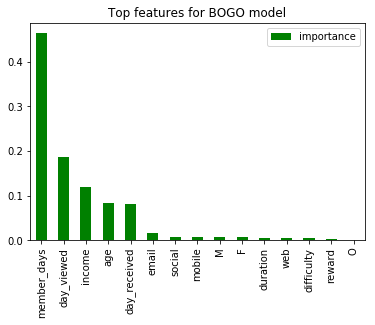

In [165]:
# Find most important features

features = bogo.drop('offer_respond', axis=1)

top_features = pd.DataFrame(bogo_2.feature_importances_,
                                   index = features.columns,
  
                            columns=['importance']).sort_values('importance',ascending=False)
top_features.plot.bar(color="green")
plt.title('Top features for BOGO model')
plt.show()


From the graph above, we can see that the most important feature that predicts if the customer will respond to an offer or not is the length in days of their Starbucks membership. What is also interesting is that day that the customer viewed the offer affected the purchase of an offer. As far as demographics income are also among the top features.

In [152]:
bogo_2.feature_importances_
features.head()

,person_id,offer_id,duration,day_viewed,day_received,age,income,member_days,F,M,O,difficulty,offer_type,reward,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,8.00,7.0,33.0,72000.0,1150.0,0.0,1.0,0.0,0,informational,0,0,0,0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,4.0,15.50,14.0,33.0,72000.0,1150.0,0.0,1.0,0.0,0,informational,0,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,19.00,17.0,33.0,72000.0,1150.0,0.0,1.0,0.0,5,bogo,5,1,1,1,1
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10.0,22.50,21.0,33.0,72000.0,1150.0,0.0,1.0,0.0,10,discount,2,1,1,1,1
14,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,7.75,7.0,40.0,57000.0,887.0,0.0,0.0,1.0,7,discount,3,1,1,1,1


### 2. Discount offer

In [133]:
X_train, X_test, y_train, y_test=model_split(discount)

# run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 10}

In [134]:
# use best parameteters

discount_2 = RandomForestClassifier(random_state = 42, max_depth = 10, max_features = 'auto',
                               min_samples_split = 10, n_estimators = 20, min_samples_leaf = 10)

results = pd.concat([results[:], run_model(discount_1, discount_2, 'discount_2')],axis=1)

RandomForestClassifier trained on 14439 samples.
MSE_train: 0.1140
MSE_test: 0.1136
Training accuracy:0.8860
Test accuracy:0.8864
             precision    recall  f1-score   support

        0.0     0.7143    0.0121    0.0238       413
        1.0     0.8868    0.9994    0.9397      3197

avg / total     0.8670    0.8864    0.8349      3610

RandomForestClassifier trained on 14439 samples.
MSE_train: 0.1107
MSE_test: 0.1130
Training accuracy:0.8893
Test accuracy:0.8870
             precision    recall  f1-score   support

        0.0     0.6471    0.0266    0.0512       413
        1.0     0.8881    0.9981    0.9399      3197

avg / total     0.8605    0.8870    0.8382      3610



In [135]:
results[['RandomForestClassifier_discount','RandomForestClassifier_discount_2']]
best_model('discount')

discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.045084,0.886981,0.239188,0.889328


In [136]:
best_model('discount')

discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.045084,0.886981,0.239188,0.889328


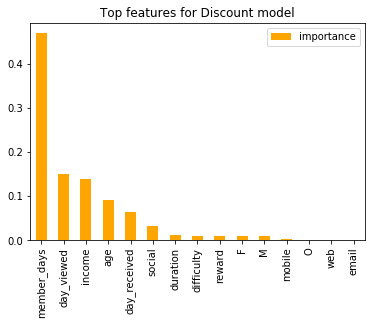

In [163]:
# Find most important features

features = discount.drop('offer_respond', axis=1)

top_features = pd.DataFrame(discount_2.feature_importances_,
                                   index = features.columns,
  
                            columns=['importance']).sort_values('importance',ascending=False)
top_features.plot.bar(color="orange")
plt.title('Top features for Discount model')
plt.show()

As we can see above,  the feature with the highest importance in predicting if the a customer will respond to an offer is the length in days of their Starbucks membership, following by day_viewed, income and age.

### 3. Informational offer

In [137]:
X_train, X_test, y_train, y_test=model_split(informational)

# run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 20}

In [138]:
info_2 = RandomForestClassifier(random_state = 42, max_depth = 10, max_features = 'auto',
                               min_samples_split = 10, n_estimators = 20, min_samples_leaf = 10)

results = pd.concat([results[:], run_model(info_1, info_2, 'info_2')],axis=1)

RandomForestClassifier trained on 7778 samples.
MSE_train: 0.2328
MSE_test: 0.2689
Training accuracy:0.7672
Test accuracy:0.7311
             precision    recall  f1-score   support

        0.0     0.7560    0.5594    0.6430       842
        1.0     0.7194    0.8622    0.7843      1103

avg / total     0.7352    0.7311    0.7231      1945

RandomForestClassifier trained on 7778 samples.
MSE_train: 0.2123
MSE_test: 0.2591
Training accuracy:0.7877
Test accuracy:0.7409
             precision    recall  f1-score   support

        0.0     0.7744    0.5665    0.6543       842
        1.0     0.7254    0.8740    0.7928      1103

avg / total     0.7466    0.7409    0.7328      1945



In [141]:
results[['RandomForestClassifier_info','RandomForestClassifier_info_2']]
best_model('info')

info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.027685,0.740874,0.133037,0.787735


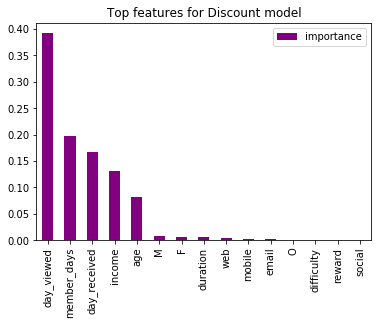

In [166]:
# Find most important features

features = informational.drop('offer_respond', axis=1)

top_features = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
  
                            columns=['importance']).sort_values('importance',ascending=False)
top_features.plot.bar(color="purple")
plt.title('Top features for Informational model')
plt.show()

As we can see above,  the feature with the highest importance in predicting if the a customer will respond to an offer is the length in days of their Starbucks membership, following by day_viewed, income and age.


In [168]:
best_models = best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

bogo RF model:
discount RF model:
info RF model:


In [169]:
best_models

,RandomForestClassifier_bogo_2,RandomForestClassifier_discount_2,RandomForestClassifier_info_2
pred_time,0.053465,0.045084,0.027685
testing_score,0.845877,0.886981,0.740874
train_time,0.279120,0.239188,0.133037
training_score,0.851004,0.889328,0.787735


We can see above an overview of the results on the training and test set for the best model for each type of offer. Overall, we managed to achieve a good accuracy in all types of offers.

# Conclusions

The data  preprocessing was particularly challenging in this project. It is indeed true that data scientists spend 80% of their time cleaning data!

After cleaning the data, we identified two main groups of customers: those who have responded to an offer, meaning that they have viewed it and performed a transaction while the offer was valid (in the duration from the day received) and customers who did see the offer but did not eventually made a purchase. Then, the dataset was splitted by offer type (BOGO, discount or informational) with the aim to explore separately what correlates with a an offer being responded for each offer type.

For each offer two classifiers were trained ( Decision Tree and Random Forest) and fine-tuning the paramets of the best one with Grid Search, we achieved a high accuracy on the test set for every type of offer. 
For the **Buy-One-Get-One: 0.85 test score** , for the **Discount:0.89 test score** and for the **Informational:0.74 test score**


For all the BOGO and the discount offers, the most important features that affected if the offer will be responded to was the **length of membership**. The longer the customer as a member of Starbucks, the more likely they will respond to the offer they receive. The second most importan feature was the day viewe. The **day viewed** was also the top feature of the informational offers, suggesting that certain days might be optimal for sending these types of offers.
As far as the demographic characteristics, **age** and **income** played an important roles as well.

## Improvements

In future iterations, I would like to try more classifiers in order to achieve better scores. The results are promising but with more time, I think the model could be more fine-tuned.

In addition, it will be interesting to try to extract some more features from the data give, like the total amount of offers a customer has received.

Finally, the cleaned dataset consisted of two groups: those who have responded to an offer and those who even though they viewed it, they didn't make a purchase. Other groups were also exracted, for example those who did buy the product regardless before viewing the offer, that could be taken consideration.